# Multiclass classification

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.preprocessing.image import load_img

In [4]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [5]:
path = './clothing-dataset-small/train/t-shirt'
name = '0add1694-17d0-46ec-a9fc-900da252af41.jpg'
fullname = f'{path}/{name}'

In [6]:
img = load_img(fullname, target_size=(299,299))

In [7]:
x = np.array(img)
x.shape

(299, 299, 3)

### Loading an exisiting model: ImageNet

In [8]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions


In [9]:
model = Xception(weights= 'imagenet', input_shape=(299,299,3))

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [10]:
X = np.array([x])

In [11]:
X.shape

(1, 299, 299, 3)

In [12]:
X = preprocess_input(X)

In [13]:
#X[0]

In [14]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [15]:
pred.shape # 1000 classes

(1, 1000)

In [16]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n03595614', 'jersey', 0.90512043),
  ('n04370456', 'sweatshirt', 0.022706838),
  ('n03710637', 'maillot', 0.0026601837),
  ('n03877472', 'pajama', 0.0020855682),
  ('n02834397', 'bib', 0.0016421458)]]

## Transfer Learning

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# for reading the images

In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [78]:
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150,150),
    batch_size=32
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150,150),
    batch_size=32,
    shuffle = False
)

Found 341 images belonging to 10 classes.
Found 3068 images belonging to 10 classes.


32, 150, 150, 3

In [21]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [22]:
X, y = next(train_ds)

In [23]:
X.shape

(32, 150, 150, 3)

In [24]:
y[:5] # one hot encoded casses
# 1 column is the class and one row is one training sample

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Model Training

In [25]:
#include top = False, removes the dense layers
base_model = Xception(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training = False)

# apply average pooling
pooling = keras.layers.GlobalAveragePooling2D()

vectors = pooling(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [26]:
outputs.shape

(None, 10)

In [27]:
preds = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [28]:
preds.shape

(32, 10)

In [29]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits = True)
# binary classification: binary cross entropy
# multi-class classification: categorical cross entropy
# regression: mean squared error

In [30]:
model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])

In [31]:
history = model.fit(train_ds, epochs = 5, validation_data = val_ds)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.3609 - loss: 6.5469 - val_accuracy: 0.6393 - val_loss: 2.1015
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.6654 - loss: 2.1546 - val_accuracy: 0.7654 - val_loss: 0.9802
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7292 - loss: 1.1658 - val_accuracy: 0.6628 - val_loss: 2.2767
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7119 - loss: 1.6997 - val_accuracy: 0.6891 - val_loss: 2.1132
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.7534 - loss: 1.5082 - val_accuracy: 0.7361 - val_loss: 1.8494


In [32]:
history.history

{'accuracy': [0.46349412202835083,
  0.6473272442817688,
  0.720664918422699,
  0.7001304030418396,
  0.7956323623657227],
 'loss': [5.19904899597168,
  2.0825672149658203,
  1.3041102886199951,
  1.8503462076187134,
  1.1695479154586792],
 'val_accuracy': [0.6392961740493774,
  0.7653958797454834,
  0.662756621837616,
  0.6891495585441589,
  0.7360703945159912],
 'val_loss': [2.1015305519104004,
  0.9802435040473938,
  2.2767157554626465,
  2.1132311820983887,
  1.8493788242340088]}

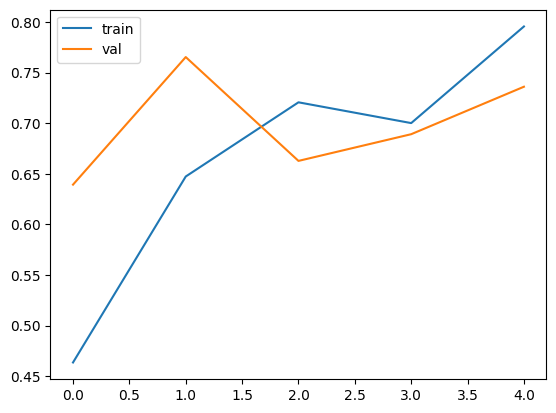

In [33]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

## Model Tuning

In [38]:
def make_model(learning_rate):
  #include top = False, removes the dense layers
  base_model = Xception(
      weights='imagenet',
      include_top = False,
      input_shape=(150,150,3)
  )

  base_model.trainable = False

  #################################
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training = False)
  # apply average pooling
  pooling = keras.layers.GlobalAveragePooling2D()
  vectors = pooling(base)
  outputs = keras.layers.Dense(10)(vectors)
  model = keras.Model(inputs, outputs)
  ##################################

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)
  model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])
  return model


In [39]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
  print(lr)
  model = make_model(learning_rate = lr)
  history = model.fit(train_ds, epochs = 10, validation_data = val_ds)
  scores[lr] = history.history
  print()
  print()

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.1936 - loss: 2.2730 - val_accuracy: 0.3724 - val_loss: 1.9160
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.4090 - loss: 1.8341 - val_accuracy: 0.4604 - val_loss: 1.6446
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.4582 - loss: 1.6839 - val_accuracy: 0.5367 - val_loss: 1.4586
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5620 - loss: 1.3674 - val_accuracy: 0.5894 - val_loss: 1.3223
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5674 - loss: 1.3489 - val_accuracy: 0.6129 - val_loss: 1.2196
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6391 - loss: 1.1451 - val_accuracy: 0.6481 - val_loss: 1.1387
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.6622 - loss: 1.0806 - val_accuracy: 0.6598 - val_loss: 1.0823
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6483 - loss: 1.0710 - val_accurac

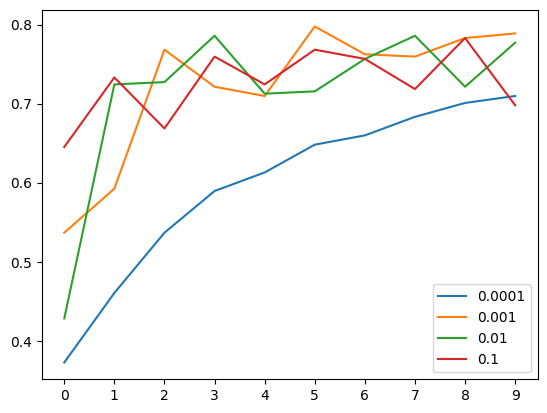

In [41]:
for lr, hist in scores.items():
  plt.plot(hist['val_accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend()

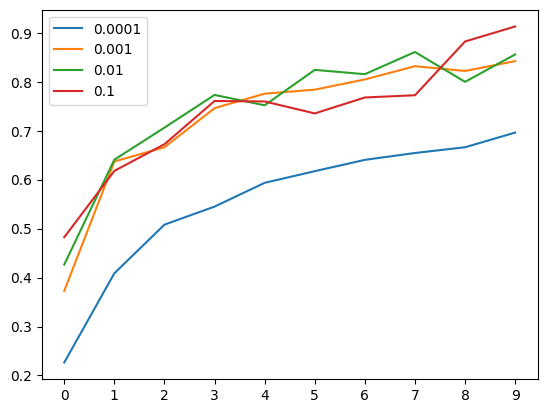

In [40]:
for lr, hist in scores.items():
  plt.plot(hist['accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend()

In [42]:
learning_rate = 0.001

## Checkpoints

In [46]:
model.save_weights('model_v1.weights.h5')

In [50]:
'xception_v1_{epoch:02d}_{validation_accuracy:.3f}.h5'.format(epoch=3, validation_accuracy =0.84)

'xception_v1_03_0.840.h5'

In [56]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only = True,
    monitor= 'val_accuracy',
    mode = 'max'
    )

In [57]:
learning_rate = 0.001

model = make_model(learning_rate = learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data =val_ds,
    callbacks =[checkpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.3080 - loss: 2.2630 - val_accuracy: 0.6305 - val_loss: 1.1283
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.6587 - loss: 1.0003 - val_accuracy: 0.7214 - val_loss: 0.8269
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7507 - loss: 0.7460 - val_accuracy: 0.7566 - val_loss: 0.7729
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7702 - loss: 0.6846 - val_accuracy: 0.7507 - val_loss: 0.7782
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7655 - loss: 0.6627 - val_accuracy: 0.7331 - val_loss: 0.7870
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.7524 - loss: 0.6626 - val_accuracy: 0.8035 - val_loss: 0.6205
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.8432 - loss: 0.4712 - val_accuracy: 0.7771 - val_loss: 0.6146
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8066 - loss: 0.5554 - val_accuracy: 0.785

## adding inner layer

In [64]:
def make_model(learning_rate, size_inner=100):
  #include top = False, removes the dense layers
  base_model = Xception(
      weights='imagenet',
      include_top = False,
      input_shape=(150,150,3)
  )

  base_model.trainable = False

  #################################
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training = False)
  # apply average pooling
  pooling = keras.layers.GlobalAveragePooling2D()
  vectors = pooling(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  outputs = keras.layers.Dense(10)(inner)

  model = keras.Model(inputs, outputs)
  ##################################

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)
  model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])
  return model


In [62]:
learning_rate = 0.001

scores= {}
for size in [10, 100, 1000]:
  print(size)

  model = make_model(learning_rate, size_inner = size)
  history = model.fit(train_ds, epochs = 10, validation_data = val_ds)
  scores[size] = history.history
  print()
  print()

10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.1965 - loss: 2.4594 - val_accuracy: 0.3021 - val_loss: 1.9626
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.2458 - loss: 1.9563 - val_accuracy: 0.3812 - val_loss: 1.6940
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.4085 - loss: 1.5599 - val_accuracy: 0.5132 - val_loss: 1.4569
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.5867 - loss: 1.3198 - val_accuracy: 0.5455 - val_loss: 1.3668
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.5262 - loss: 1.2532 - val_accuracy: 0.5337 - val_loss: 1.2809
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.5471 - loss: 1.3031 - val_accuracy: 0.5543 - val_loss: 1.2226
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5949 - loss: 1.1251 - val_accuracy: 0.5660 - val_loss: 1.2070
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.5657 - loss: 1.1386 - val_accuracy: 0.

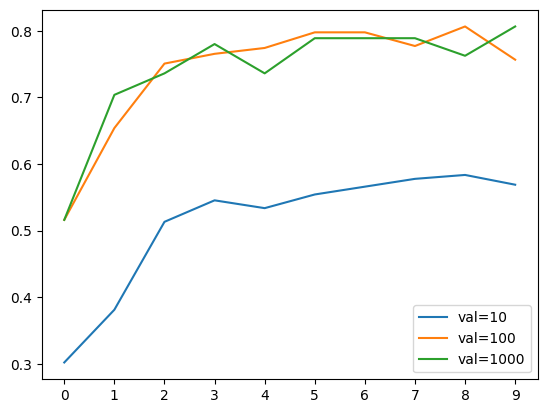

In [63]:
for size, hist in scores.items():

  plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.legend()


## Regularization and Dropout

in Dropout the network sees a partially occluded datapoint in different epochs to avoid learning patterns unwanted patterns like classifying a t short based on a logo, or a background

freeze asome neurons of the layer

In [65]:
def make_model(learning_rate, size_inner=100, drop_rate = 0.5):
  #include top = False, removes the dense layers
  base_model = Xception(
      weights='imagenet',
      include_top = False,
      input_shape=(150,150,3)
  )

  base_model.trainable = False

  #################################
  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training = False)
  # apply average pooling
  pooling = keras.layers.GlobalAveragePooling2D()
  vectors = pooling(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(drop_rate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ##################################

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)
  model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])
  return model



In [75]:
learning_rate = 0.001
size = 100

scores= {}
for droprate in [0.0, 0.2, 0.5]:
  print(size)

  model = make_model(learning_rate, size_inner = size, drop_rate=droprate)
  history = model.fit(train_ds, epochs = 12, validation_data = val_ds)
  scores[droprate] = history.history
  print()
  print()

100
Epoch 1/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.3246 - loss: 2.2575 - val_accuracy: 0.5806 - val_loss: 1.2020
Epoch 2/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.5728 - loss: 1.2497 - val_accuracy: 0.6950 - val_loss: 0.8930
Epoch 3/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.7238 - loss: 0.8368 - val_accuracy: 0.6979 - val_loss: 0.8828
Epoch 4/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.7200 - loss: 0.8031 - val_accuracy: 0.8035 - val_loss: 0.7013
Epoch 5/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7632 - loss: 0.7035 - val_accuracy: 0.7566 - val_loss: 0.7208
Epoch 6/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.7894 - loss: 0.5928 - val_accuracy: 0.8182 - val_loss: 0.6191
Epoch 7/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8219 - loss: 0.5318 - val_accuracy: 0.7625 - val_loss: 0.6629
Epoch 8/12
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8294 - loss: 0.4859 - val_accu

0.0
0.2
0.5


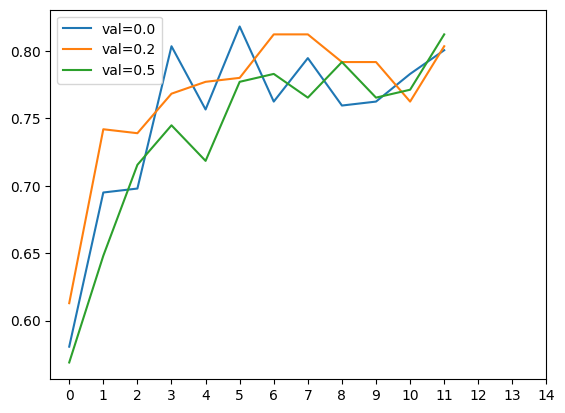

In [76]:
for droprate, hist in scores.items():
  print(droprate)
  plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.xticks(np.arange(12))
plt.legend()

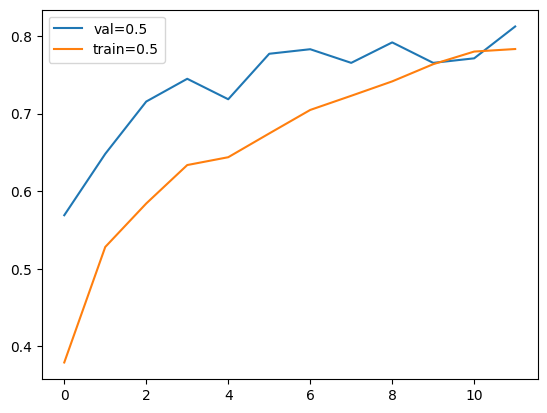

In [79]:
hist = scores[0.5]
plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.plot(hist['accuracy'], label=('train=%s' % droprate))
plt.legend()

preferable to take an accuracy at a lower epoch than same accuracy but later epoc, cause gth emodel overfits

Dropout prevents overfitting so it is better than none

## Data augementation

Generate variations od input images  
flip, vertical or horizontal  
rotation
shifting (translation)  
shear  
zoom
brightness and contrast  
black patch
can also be combined

In [80]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rotation_range=30, performance got worse
    ##width_shift_range=10.0,
    #height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True
)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150,150),
    batch_size=32
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150,150),
    batch_size=32,
    shuffle = False
)

Found 341 images belonging to 10 classes.
Found 3068 images belonging to 10 classes.


In [ ]:
learning_rate = 0.001
size = 100
droprate = 0.2
scores= {}
#for droprate in [0.0, 0.2, 0.5]:
  #print(size)

model = make_model(learning_rate, size_inner = size, drop_rate=droprate)
history = model.fit(train_ds, epochs = 50, validation_data = val_ds)
scores[droprate] = history.history
print()
print()

use tf.data to preprocess the next batch while running the training step and reduce time drastically

## Train a larger model

In [86]:
def make_model(input_size = 150, learning_rate=0.01, size_inner=100, drop_rate = 0.5):
  #include top = False, removes the dense layers
  base_model = Xception(
      weights='imagenet',
      include_top = False,
      input_shape=(input_size,input_size,3)
  )

  base_model.trainable = False

  #################################
  inputs = keras.Input(shape=(input_size,input_size,3))
  base = base_model(inputs, training = False)
  # apply average pooling
  pooling = keras.layers.GlobalAveragePooling2D()
  vectors = pooling(base)
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
  drop = keras.layers.Dropout(drop_rate)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)
  ##################################

  optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)
  model.compile(optimizer=optimizer, loss = loss, metrics = ['accuracy'])
  return model

In [87]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only = True,
    monitor= 'val_accuracy',
    mode = 'max'
    )

In [91]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rotation_range=30, performance got worse
    ##width_shift_range=10.0,
    #height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True
)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(299,299),
    batch_size=32
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(299,299),
    batch_size=32,
    shuffle = False
)

Found 341 images belonging to 10 classes.
Found 3068 images belonging to 10 classes.


In [93]:
learning_rate = 0.001
size = 100
droprate = 0.2
input_size = 299
scores= {}
#for droprate in [0.0, 0.2, 0.5]:
  #print(size)

model = make_model(
    input_size= input_size,
    learning_rate= learning_rate,
    size_inner = size,
    drop_rate=droprate
)

history = model.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks=[checkpoint])
scores[droprate] = history.history
print()
print()

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 94s 847ms/step - accuracy: 0.3012 - loss: 2.2413 - val_accuracy: 0.5777 - val_loss: 1.2345
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 747ms/step - accuracy: 0.5252 - loss: 1.3655 - val_accuracy: 0.6804 - val_loss: 0.8905
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 981ms/step - accuracy: 0.6283 - loss: 1.1663 - val_accuracy: 0.7390 - val_loss: 0.7620
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 91s 891ms/step - accuracy: 0.6916 - loss: 0.9898 - val_accuracy: 0.7713 - val_loss: 0.6537
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 80s 775ms/step - accuracy: 0.7345 - loss: 0.8187 - val_accuracy: 0.7801 - val_loss: 0.6651
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 703ms/step - accuracy: 0.7508 - loss: 0.7311 - val_accuracy: 0.8123 - val_loss: 0.5705
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 718ms/step - accuracy: 0.7567 - loss: 0.7011 - val_accuracy: 0.8299 - val_loss: 0.5350
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 73s 707ms/step - accuracy: 0.7623 - loss: 0.7143 - val_acc

## testing the model

In [102]:
import tensorflow as tf
from tensorflow import keras

In [103]:
model = keras.models.load_model('xception_v4_07_0.830.keras')

In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

In [108]:
ls

clothing-dataset-small/     xception_v1_09_0.809.keras  xception_v4_04_0.771.keras
model_v1.weights.h5         xception_v4_01_0.578.keras  xception_v4_05_0.780.keras
sample_data/                xception_v4_02_0.680.keras  xception_v4_06_0.812.keras
xception_v1_06_0.804.keras  xception_v4_03_0.739.keras  xception_v4_07_0.830.keras


In [109]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    'clothing-dataset-small/test',
    target_size=(299,299),
    batch_size=32
)


Found 372 images belonging to 10 classes.


In [110]:
model.evaluate(test_ds)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8133 - loss: 0.5003


[0.43859919905662537, 0.8494623899459839]

In [111]:
path = 'clothing-dataset-small/test/pants/0dfec862-c49f-430b-a6ef-c7ceb187225e.jpg'

In [112]:
img = load_img(path, target_size=(299,299))

In [113]:
import numpy as np

In [114]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [115]:
X = preprocess_input(X)

In [116]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [117]:
pred[0]

array([-2.5598445 , -4.682142  , -0.20521203, -0.8227664 ,  5.1831923 ,
       -1.2658001 , -2.0810783 ,  1.988449  , -2.3323476 , -4.5970945 ],
      dtype=float32)

In [118]:
classes = ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


In [119]:
dict(zip(classes, pred[0]))

{'dress': -2.5598445,
 'hat': -4.682142,
 'longsleeve': -0.20521203,
 'outwear': -0.8227664,
 'pants': 5.1831923,
 'shirt': -1.2658001,
 'shoes': -2.0810783,
 'shorts': 1.988449,
 'skirt': -2.3323476,
 't-shirt': -4.5970945}

In [129]:
from tensorflow.keras.activations import softmax
tf.keras.activations.softmax(np.array([1.3, 5.4]))


<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.0163025, 0.9836975])>

In [137]:
from scipy.special import softmax

In [139]:
input = pred[0]
result = softmax(input)
dict(zip(classes, result))

{'dress': 0.00041255556,
 'hat': 4.940611e-05,
 'longsleeve': 0.004345965,
 'outwear': 0.0023436132,
 'pants': 0.9511315,
 'shirt': 0.0015048003,
 'shoes': 0.00066589814,
 'shorts': 0.038974565,
 'skirt': 0.0005179442,
 't-shirt': 5.3791788e-05}